In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram

from tracefc.io.session_directory import get_session_dir


In [2]:
# Define a class for a typical recording or set of recordings
class ProcessData:
    def __init__(self, basepath):
        basepath = Path(basepath)
        self.basepath = basepath
        xml_files = sorted(basepath.glob("*.xml"))
        assert len(xml_files) == 1, "Found more than one .xml file"
        
        fp = xml_files[0].with_suffix("")
        self.filePrefix = fp
        
        self.recinfo = NeuroscopeIO(xml_files[0])
        eegfiles = sorted(basepath.glob('*.eeg'))
        assert len(eegfiles) == 1, "Fewer/more than one .eeg file detected"
        self.eegfile = BinarysignalIO(eegfiles[0], n_channels=self.recinfo.n_channels,
                                     sampling_rate=self.recinfo.eeg_sampling_rate,
                                     )
        try:
            self.datfile = BinarysignalIO(eegfiles[0].with_suffix('.dat'),
                                         n_channels=self.recinfo.n_channels,
                                         sampling_rate=self.recinfo.dat_sampling_rate,
                                         )
        except FileNotFoundError:
            print('No dat file found, not loading')
                
        
    def __repr__(self) -> str:
        return f"{self.__class__.__name__}({self.recinfo.source_file.name})"
    
def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [3]:
animal, sess_name = 'Finn', 'recall1'
sess_dir = get_session_dir(animal, sess_name)
sess = sess_use(sess_dir)
print(sess.recinfo)

No dat file found, not loading
filename: /data/Working/Trace_FC/Recording_Rats/Finn/2022_01_27_recall7/Finn_recall7_denoised.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [4]:
print(sess.eegfile)

duration: 3276.34 seconds 
duration: 0.91 hours 



# Preprocess Ephys data
Identify artifacts:  
- disconnects  
- filtering  
  
Send to event files to check in Neuroscope  
Write `dead_times.txt` file for spyking-circus and `artifacts.npy` file for my own analysis.

### Identify disconnect and motion artifacts

In [6]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.1  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    art_epochs = detect_artifact_epochs(signal, thresh=8, 
                                    edge_cutoff=3, merge=6)

    # Code to add in artifact epochs manually - comment out after using
    # art_epochs = art_epochs.add_epoch_manually(538, 560)
    # art_epochs = art_epochs.add_epoch_manually(1588, 1615)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)
art_epochs

Buffer of 0.1 added before/after each epoch
/data/Working/Trace_FC/Recording_Rats/Finn/2022_01_27_recall7/Finn_recall7_denoised.art_epochs.npy saved


14 epochs
Snippet: 
        start       stop label
0    59.4048    59.9824      
1    95.8328    96.0864      
2   109.9352   130.6448      
3   153.0552   156.2536      
4  1318.1464  1330.0472      

<Axes: >

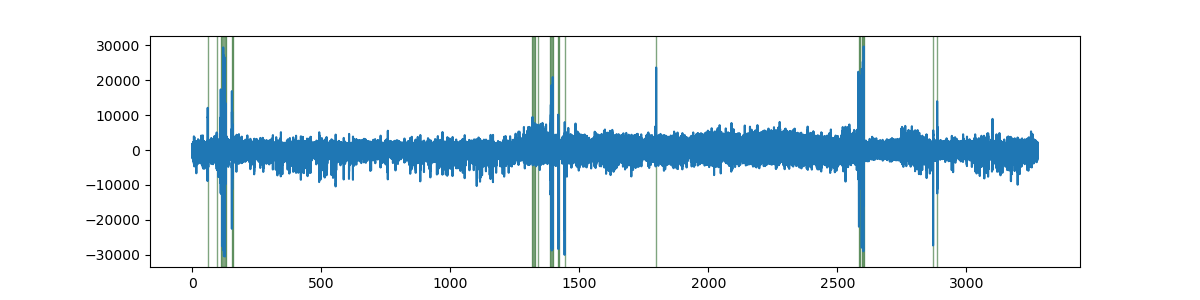

In [7]:
%matplotlib widget

chan_plot = 28
plot_signal_w_epochs(signal, 28, art_epochs)

## Define probe group

/data/Working/Trace_FC/Recording_Rats/Finn/2022_01_27_recall7/Finn_recall7_denoised.probegroup.npy saved


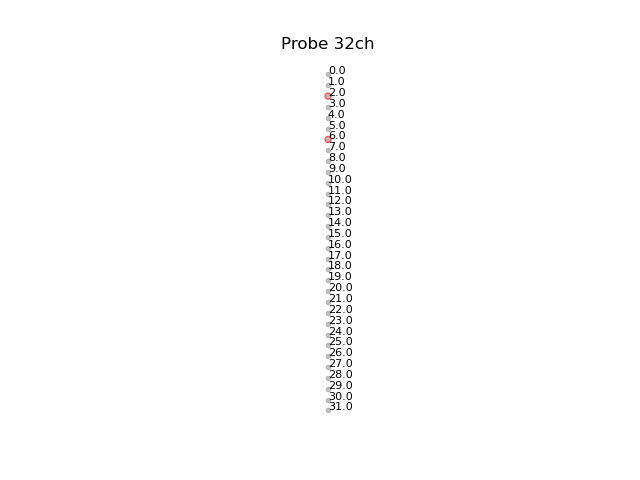

In [8]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=20, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

# Detect Theta epochs

In [11]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=0.25
maxdur=20
thresh = (0.5, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 31

# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)

Best channel for theta: [31]
1266 epochs remaining with durations within (0.25,20)


## Detect SWR Epochs

In [12]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 29
thresh = (3, None)  # conservative but good
ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                     ignore_epochs=art_epochs)


Selected channels for ripples: [29]
408 epochs remaining with durations within (0.05,0.45)


# Wavelet Analysis

### Start with Theta

In [13]:
# Run wavelet on theta range
theta_range = np.arange(4, 14, 0.25)  # How do I select these? 0.25Hz seems good to start
wv_theta = WaveletSg(signal.time_slice(channel_id=theta_channel), freqs=theta_range, sigma=None)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

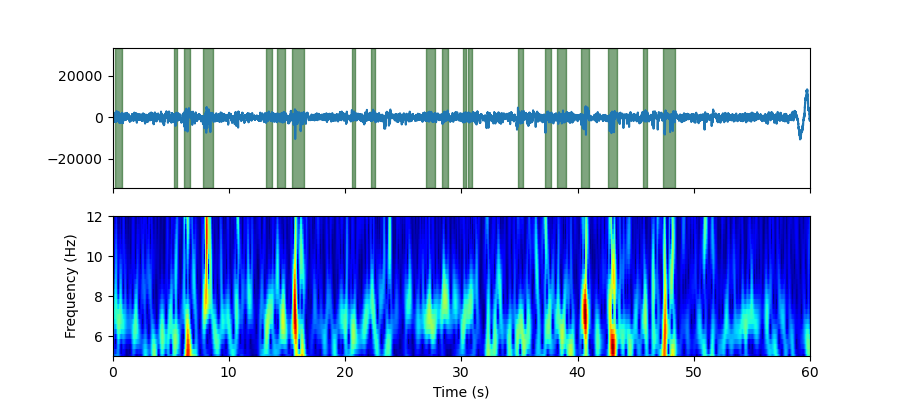

In [14]:
# Sanity check code - does wavelet align well with actual theta epochs?
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
theta_freq_lims = [5, 12]

plot_signal_w_epochs(signal, theta_channel, theta_epochs, ax=ax[0])

plot_spectrogram(wv_theta, time_lims=time_to_plot, freq_lims=theta_freq_lims, ax=ax[1])

### Mean spectrogram at theta starts

Events [   0 1265] are outside of data range and were dropped


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 0, 'Time from Theta epoch start (sec)')

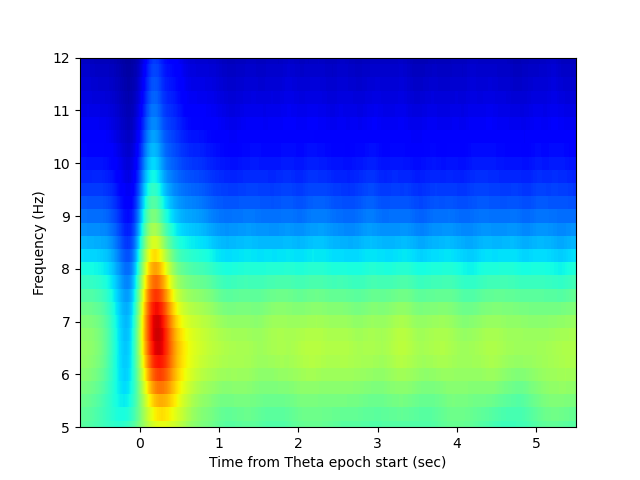

In [16]:
theta_buffer_sec = (0.75, 5.5)
wv_theta_mean = wv_theta.get_pe_mean_spec(theta_epochs.starts, buffer_sec=theta_buffer_sec)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(theta_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from Theta epoch start (sec)')

### Try out SWRs

In [17]:
swr_range = np.arange(125, 275, 5)
wv_swr = WaveletSg(signal.time_slice(channel_id=ripple_channel), freqs=swr_range, sigma=None)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

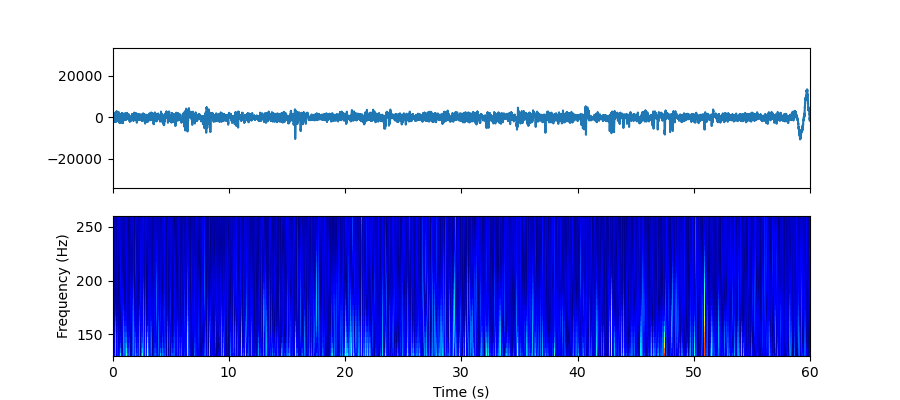

In [18]:
# Sanity check code - does wavelet align well with actual theta epochs?
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
swr_freq_lims = [130, 260]

plot_signal_w_epochs(signal, theta_channel, ripple_epochs, ax=ax[0])

plot_spectrogram(wv_swr, time_lims=time_to_plot, freq_lims=swr_freq_lims, ax=ax[1])

### Mean spectrogram at all ripples

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from Ripple Peak (sec)')

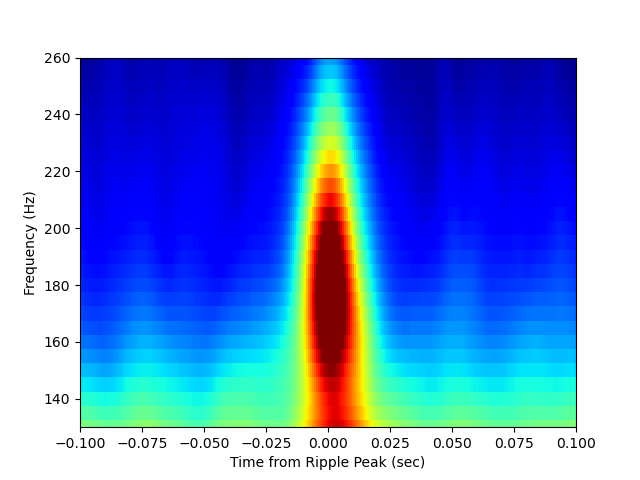

In [19]:
ripple_buffer_sec = (0.1, 0.1)
wv_swr_mean = wv_swr.get_pe_mean_spec(ripple_epochs.to_dataframe()['peak_time'].values, buffer_sec=ripple_buffer_sec)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(ripple_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from Ripple Peak (sec)')

## Peri-CS analyses

,channel_states,timestamps,datetimes,event_name
0,-2,1352647,2022-01-27 12:35:23.088233333,
301,2,5020097,2022-01-27 12:37:25.336566667,
302,-2,5317738,2022-01-27 12:37:35.257933333,
1099,2,7298096,2022-01-27 12:38:41.269866667,
1248,-2,7596231,2022-01-27 12:38:51.207700000,


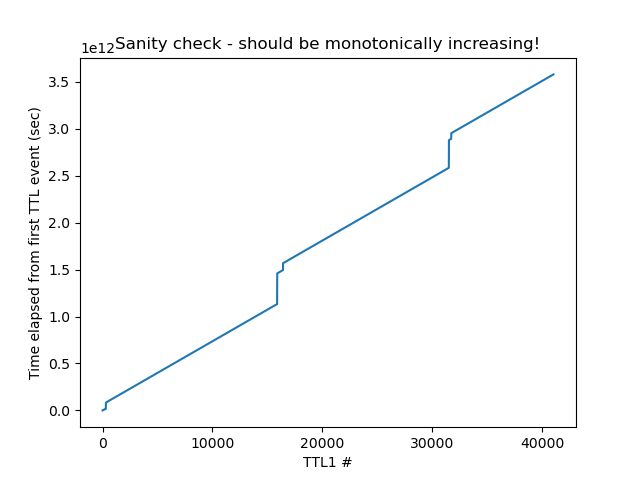

In [20]:
import neuropy.io.openephysio as oeio

# Import TTLs for CS from OpenEphys
ttl_df = oeio.load_all_ttl_events(sess.basepath, sanity_check_channel=1, zero_timestamps=True)
ttl_df[ttl_df['channel_states'].abs() == 2].head(5)

In [24]:
import tracefc.io.traceio as traceio

# For tone recall CS+
cs_starts, cs_ends, cs_df = traceio.load_trace_events(sess.basepath, session_type="tone_recall", 
                                                      event_type="CS+", return_df=True)
print(f'{cs_starts.shape[0]} CS+ events detected')
print(cs_starts.head(6))

# For control tone recall CS-
csn_starts, csn_ends, csn_df = traceio.load_trace_events(sess.basepath, session_type="control_tone_recall", 
                                                      event_type="CS-", return_df=True)
print(f'{csn_starts.shape[0]} CS- events detected')
print(csn_starts.head(6))


# For CS+ at end of control_tone_recall
cs2_starts, cs2_ends, cs2_df = traceio.load_trace_events(sess.basepath, session_type="control_tone_recall", 
                                                      event_type="CS+", return_df=True)
print(f'{cs2_starts.shape[0]} CS+ events detected')
print(cs2_starts.head(6))

15 CS+ events detected
      Time (s)      Event                     Timestamp
5    61.013983  CS1_start 2022-01-27 12:37:25.471877488
7   136.946709  CS2_start 2022-01-27 12:38:41.404603394
9   197.893818  CS3_start 2022-01-27 12:39:42.351712378
11  277.847069  CS4_start 2022-01-27 12:41:02.304963263
13  352.776171  CS5_start 2022-01-27 12:42:17.234065446
15  426.725596  CS6_start 2022-01-27 12:43:31.183489951
12 CS- events detected
      Time (s)      Event                     Timestamp
5    60.837843  CS1_start 2022-01-27 13:01:39.919239703
7   121.761522  CS2_start 2022-01-27 13:02:40.842919293
9   189.712134  CS3_start 2022-01-27 13:03:48.793531123
11  250.660771  CS4_start 2022-01-27 13:04:49.742167655
13  316.591643  CS5_start 2022-01-27 13:05:55.673039857
15  390.543099  CS6_start 2022-01-27 13:07:09.624495688
3 CS+ events detected
       Time (s)           Event                     Timestamp
29   899.161654  CS_end_1_start 2022-01-27 13:15:38.243050757
31   967.091325  CS_end_

In [23]:
sync_df = oeio.create_sync_df(sess.basepath)
sync_df

start time = 2022-01-27 12:34:38.161110-05:00
start time = 2022-01-27 12:58:32.342074-05:00
start time = 2022-01-27 13:23:32.483697-05:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time
0,0,2022-01-27 12:34:38.161110-05:00,start,0,0.000000,0,0.0000
1,0,2022-01-27 12:55:30.606943333-05:00,stop,37573375,1252.445833,1565557,1252.4456
2,1,2022-01-27 12:58:32.342074-05:00,start,37573376,1252.445867,1565558,1252.4464
3,1,2022-01-27 13:19:37.263640667-05:00,stop,75521023,2517.367433,3146709,2517.3672
4,2,2022-01-27 13:23:32.483697-05:00,start,75521024,2517.367467,3146710,2517.3680
5,2,2022-01-27 13:36:11.455397-05:00,stop,98290175,3276.339167,4095423,3276.3384


In [26]:
# Grab CS times corresponding to OE timestamps
ttl_lag_use = ttl_lag=pd.Timedelta(0.8, unit="seconds")
cs_oe_start_df = traceio.trace_ttl_to_openephys(cs_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use)
# Convert to times in combined eeg file
cs_starts_combined = oeio.recording_events_to_combined_time(cs_oe_start_df, sync_df)

csn_oe_start_df = traceio.trace_ttl_to_openephys(csn_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2)

# Convert to times in combined eeg file
csn_starts_combined = oeio.recording_events_to_combined_time(csn_oe_start_df, sync_df)


cs2_oe_start_df = traceio.trace_ttl_to_openephys(cs2_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use)
# Convert to times in combined eeg file
cs2_starts_combined = oeio.recording_events_to_combined_time(cs2_oe_start_df, sync_df)

start time lag: mean = -0.1332605618, std = 0.0018417276616603869
start time lag: mean = -0.31276219850000003, std = 0.0005560237039939796
start time lag: mean = -0.31166691399999996, std = 0.00023240432791149913


/data/GitHub/TraceFC/tracefc/io/traceio.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace_cs_sync_df["datetimes"] = trace_cs_sync_df["datetimes"].dt.tz_localize(


## Theta mean spectrogram

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

828 frames between 1442.6 and 1443.3 ignored (sent to nan)
341 frames between 1797.6 and 1797.8 ignored (sent to nan)


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 1.0, 'CS+ at end of control tone recall session')

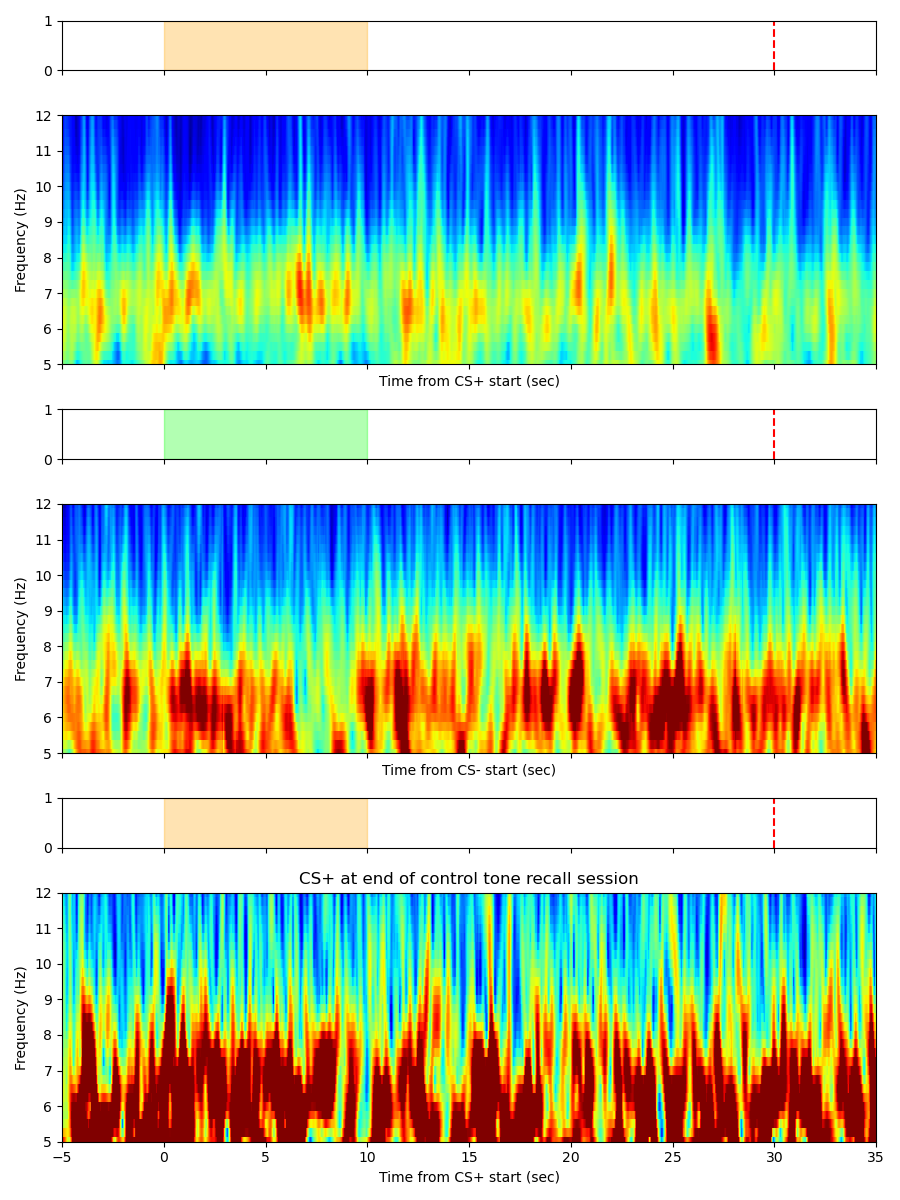

In [29]:
from tracefc.plotting.signals import plot_cs_mean_wavelet
cs_buffer = (5, 35)

_, ax = plt.subplots(6, 1, figsize=(9, 12), height_ratios=[1, 5, 1, 5, 1, 5], layout='tight', sharex=True)

_, std_sxx = plot_cs_mean_wavelet(wv_theta, cs_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                     ignore_epochs=art_epochs, ax=ax[:2])
plot_cs_mean_wavelet(wv_theta, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                     ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[2:4])
plot_cs_mean_wavelet(wv_theta, cs2_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                     ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[4:])
ax[5].set_title('CS+ at end of control tone recall session')


# For habituation sessions
# plot_cs_mean_wavelet(wv_theta, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
#                      ignore_epochs=art_epochs, std_sxx=None, ax=ax[2:])

## Ripple mean spectrogram

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

828 frames between 1442.6 and 1443.3 ignored (sent to nan)
341 frames between 1797.6 and 1797.8 ignored (sent to nan)


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 1.0, 'CS+ at end of control tone recall session')

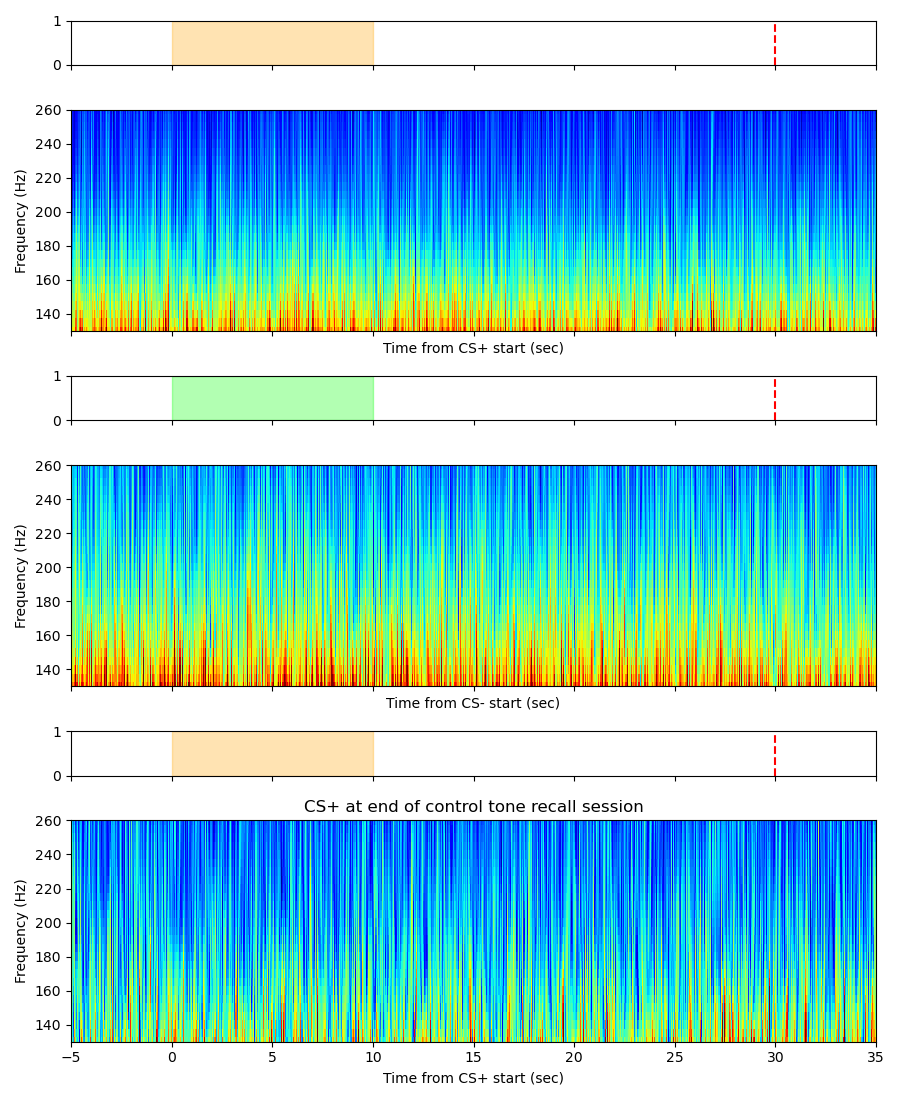

In [30]:
cs_buffer = (5, 35)

_, ax = plt.subplots(6, 1, figsize=(9, 11), height_ratios=[1, 5, 1, 5, 1, 5], layout='tight', sharex=True)

_, std_sxx = plot_cs_mean_wavelet(wv_swr, cs_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
                     ignore_epochs=art_epochs, ax=ax[:2])
plot_cs_mean_wavelet(wv_swr, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
                     ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[2:4])
plot_cs_mean_wavelet(wv_swr, cs2_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
                     ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[4:])
ax[5].set_title('CS+ at end of control tone recall session')

# # For habituation sessions
# plot_cs_mean_wavelet(wv_swr, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
#                      ignore_epochs=art_epochs, std_sxx=None, ax=ax[2:])

## Save notebook to working directory

In [31]:
from neuropy.utils.manipulate_files import save_notebook
save_notebook(sess.basepath, save_prepend=f"{animal}_{sess_name}_")

/data/GitHub/TraceFC/Notebooks/Spectral_Analysis.ipynb saved to /data/Working/Trace_FC/Recording_Rats/Finn/2022_01_27_recall7/Finn_recall7_Spectral_Analysis.ipynb
